In [1]:
import os
import json
from pathlib import Path
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt


from data import get_dataset, get_zoo_elephants_images_and_labels, get_ELEP_images_and_labels
from train import SiameseModel
from metrics import get_kernel_mask, val
from model import get_model
from triplet_loss import batch_all_triplet_loss, _pairwise_distances, _get_anchor_positive_triplet_mask, val, far

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.models import load_model

In [182]:
with open('hyperparameters/initial_run.json', 'rb') as f:
    params = json.load(f)

In [183]:
params['batch_size']['train'] = 50
params['batch_size']['val'] = 50
params['val_rate_d'] = 0.5

In [184]:
params

{'image_size': 256,
 'batch_size': {'train': 50, 'val': 50},
 'margin': 0.25,
 'squared': True,
 'embedding_size': 256,
 'lr': 0.0001,
 'dense_l2_reg_c': 0.0003,
 'val_rate_d': 0.5}

In [185]:
data_dir = '/Users/deepakduggirala/Documents/ELPephant-cropped'

In [186]:
cache_files = {
        'train': 'train.cache',
        'val': 'val.cache'
    }

In [187]:
train_ds, N_train = get_dataset(get_ELEP_images_and_labels, params, data_dir, 'train', cache_files)
val_ds, N_val = get_dataset(get_ELEP_images_and_labels, params, data_dir, 'val', cache_files)

reading Tensor("args_0:0", shape=(), dtype=string)
reading Tensor("args_0:0", shape=(), dtype=string)


In [17]:
class SiameseModel(Model):
    def __init__(self, params, finetune):
        super().__init__()
        self.params = params
        self.finetune = finetune
        self.siamese_network = get_model(params, finetune)
        self.custom_loss = batch_all_triplet_loss
        self.val_metric = val
        self.far_metric = far
        self.loss_tracker = metrics.Mean(name="loss")
        self.val_rate_tracker = metrics.Mean(name="VAL")
        self.far_rate_tracker = metrics.Mean(name="FAR")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            loss, embeddings = self._compute_loss(images, labels) 
            loss = loss + sum(self.siamese_network.losses)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        
        val_rate = self.val_metric(labels, embeddings, d=self.params['val_rate_d'],  squared=self.params['squared'])
        self.val_rate_tracker.update_state(val_rate)
        
        far_rate = self.far_metric(labels, embeddings, d=self.params['val_rate_d'],  squared=self.params['squared'])
        self.far_rate_tracker.update_state(far_rate)

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result(), "VAL": self.val_rate_tracker.result(), "FAR": self.far_rate_tracker.result()}

    def test_step(self, data):
        images, labels = data
        loss, embeddings = self._compute_loss(images, labels)

        # tf.print(tf.norm(embeddings, axis=1))
        
        val_rate = self.val_metric(labels, embeddings, d=self.params['val_rate_d'],  squared=self.params['squared'])
        self.val_rate_tracker.update_state(val_rate)
        
        far_rate = self.far_metric(labels, embeddings, d=self.params['val_rate_d'],  squared=self.params['squared'])
        self.far_rate_tracker.update_state(far_rate)
        
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result(), "VAL": self.val_rate_tracker.result(), "FAR": self.far_rate_tracker.result()}

    def _compute_loss(self, images, labels):
        embeddings = self.siamese_network(images)
        embeddings = tf.math.l2_normalize(embeddings, axis=1, epsilon=1e-10)
        
        return self.custom_loss(labels, embeddings, self.params['margin'], self.params['squared']), embeddings

In [8]:
siamese_model = SiameseModel(params, False)
siamese_model.compile(optimizer=optimizers.Adam(params['lr']))

In [9]:
siamese_model.fit(train_ds.take(1),
                      epochs=4,
                      validation_data=val_ds.take(1))

Epoch 1/4


2022-04-23 14:20:17.413543: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 7s 7s/step - loss: 0.4157 - VAL: 0.6000 - FAR: 0.7730 - val_loss: 0.2067 - val_VAL: 1.0000 - val_FAR: 0.8430
Epoch 2/4
1/1 [==============================] - 6s 6s/step - loss: 0.3599 - VAL: 0.9000 - FAR: 0.8420 - val_loss: 0.2576 - val_VAL: 0.8400 - val_FAR: 0.7542
Epoch 3/4
1/1 [==============================] - 6s 6s/step - loss: 0.3587 - VAL: 0.8750 - FAR: 0.8200 - val_loss: 0.2253 - val_VAL: 1.0000 - val_FAR: 0.8855
Epoch 4/4
1/1 [==============================] - 5s 5s/step - loss: 0.3975 - VAL: 0.8000 - FAR: 0.8607 - val_loss: 0.2865 - val_VAL: 0.7368 - val_FAR: 0.8018


In [188]:
images, labels = next(val_ds.as_numpy_iterator())

In [189]:
tf_images = tf.convert_to_tensor(images)
tf_labels = tf.convert_to_tensor(labels)

In [30]:
tf_images.shape, tf_labels.shape

(TensorShape([50, 256, 256, 3]), TensorShape([50]))

In [31]:
embeddings = siamese_model.siamese_network(images)

In [32]:
tf_embeddings = tf.convert_to_tensor(embeddings)
tf_embeddings.shape

TensorShape([50, 256])

In [102]:
pairwise_dist = _pairwise_distances(tf_embeddings_norm, squared=False)

In [103]:
pairwise_dist

<tf.Tensor: shape=(50, 50), dtype=float32, numpy=
array([[0.        , 0.68123555, 0.70504946, ..., 0.70138097, 0.8714106 ,
        0.93182284],
       [0.68123555, 0.        , 0.7360683 , ..., 0.77634454, 0.88125825,
        1.0584412 ],
       [0.70504946, 0.7360683 , 0.        , ..., 0.70425594, 0.6904418 ,
        0.859302  ],
       ...,
       [0.70138097, 0.77634454, 0.70425594, ..., 0.        , 0.71575445,
        1.0140395 ],
       [0.8714106 , 0.88125825, 0.6904418 , ..., 0.71575445, 0.        ,
        0.96042514],
       [0.93182284, 1.0584412 , 0.859302  , ..., 1.0140394 , 0.96042514,
        0.        ]], dtype=float32)>

In [35]:
tf_labels

<tf.Tensor: shape=(50,), dtype=string, numpy=
array([b'3061', b'3134', b'5778', b'3061', b'842', b'1184', b'1890',
       b'953', b'842', b'1890', b'866', b'4829', b'5061', b'101', b'1867',
       b'1867', b'3134', b'770', b'5061', b'1450', b'3061', b'4254',
       b'647', b'2281', b'5061', b'28', b'1994', b'5061', b'1595',
       b'1469', b'842', b'4339', b'1248', b'3428', b'1146', b'379',
       b'1469', b'647', b'2764', b'1248', b'2764', b'5061', b'3637',
       b'4339', b'1214', b'4030', b'28', b'4030', b'5778', b'647'],
      dtype=object)>

In [42]:
mask_anchor_positive = _get_anchor_positive_triplet_mask(tf_labels)
mask_anchor_positive = tf.cast(mask_anchor_positive, dtype=tf.float32)
mask_anchor_positive

<tf.Tensor: shape=(50, 50), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [53]:
anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)
anchor_positive_dist

<tf.Tensor: shape=(50, 50), dtype=float32, numpy=
array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 7.414732, 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 7.414732, ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]],
      dtype=float32)>

In [58]:
valid_pairs = tf.reduce_sum(mask_anchor_positive)

In [89]:
false_rejects = tf.reduce_sum(tf.cast(tf.greater(anchor_positive_dist, 100), dtype=tf.float32))

In [60]:
true_accepts = valid_pairs - false_rejects
true_accepts/valid_pairs


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [104]:
def val(labels, embeddings, d, squared=False):
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.cast(mask_anchor_positive, dtype=tf.float32)
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)
    
    valid_pairs = tf.reduce_sum(mask_anchor_positive)
    false_rejects = tf.reduce_sum(tf.cast(tf.greater(anchor_positive_dist, d), dtype=tf.float32))
    true_accepts = valid_pairs - false_rejects
    
    # tf.print(valid_pairs, false_rejects, true_accepts)
    
    return true_accepts/valid_pairs

In [11]:
def far(labels, embeddings, d, squared=False):
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.cast(mask_anchor_negative, dtype=tf.float32)
    anchor_negative_dist = tf.multiply(mask_anchor_negative, pairwise_dist)
    
    invalid_pairs = tf.reduce_sum(mask_anchor_negative)
    true_reject = tf.reduce_sum(tf.cast(tf.greater(anchor_negative_dist, d), dtype=tf.float32))
    false_accepts = invalid_pairs - true_reject
    
    # tf.print(valid_pairs, false_rejects, true_accepts)
    
    return false_accepts/invalid_pairs

In [101]:
val(tf_labels, tf_embeddings_norm, 12)

58 6 52


<tf.Tensor: shape=(), dtype=float32, numpy=0.8965517>

In [ ]:
val()

In [92]:
tf_embeddings_norm = tf.math.l2_normalize(tf_embeddings, axis=1, epsilon=1e-10)

In [93]:
tf.norm(tf_embeddings_norm, axis=1)

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0.99999994, 1.        , 1.0000001 , 1.        , 1.        ,
       0.99999994, 1.        , 0.99999994, 0.99999994, 1.0000001 ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 0.99999994, 0.9999999 , 0.9999999 , 0.9999999 ,
       1.        , 0.99999994, 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.0000001 , 1.        , 1.        ,
       1.        , 0.99999994, 0.99999994, 1.        , 0.99999994,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       0.9999999 , 1.        , 0.99999994, 1.        , 1.        ],
      dtype=float32)>

In [17]:
np.sqrt(2 - 2 * np.cos(2 * np.pi / 10))

0.6180339887498948

In [13]:
2 * np.pi / 100

0.06283185307179587

In [111]:
def expected_mindist(D, N):
    total_theta = []
    total_d = []
    for i in range(100):
        a = np.random.uniform(low =-1, high=1, size=(N, D))
        b = np.random.uniform(low =-1, high=1, size=(D, 1))
        a = a/ np.linalg.norm(a, axis=1, keepdims=1)
        b = b/ np.linalg.norm(b, axis=0, keepdims=1)
        e = a @ b
        theta = np.min(np.arccos( e))
        d = np.min(np.sqrt(2 - 2 * e))
        total_theta.append(theta)
        total_d.append(d)
    return np.mean(total_d), np.rad2deg(np.mean(total_theta))
    

In [180]:
min_dist, min_deg = expected_mindist(256, 2000)
min_dist, min_deg

(1.253034584417194, 77.59299064079796)

In [107]:
min_dist, min_deg

(1.05310896715913, 63.55957225865585)

In [95]:
# Fixed N and changing D
results = []
for i in 2**np.arange(1, 11):
    print(i)
    results.append(expected_mindist(i, 1600))
    

2
4
8
16
32
64
128
256
512
1024


In [122]:
# Fixed D and changing N
results = []
for i in 10**np.arange(3, 7):
    print(i)
    results.append(expected_mindist(8, i))

1000
10000
100000
1000000


In [123]:
min_dists, min_degs = list(zip(*results))
min_dists, min_degs

((0.4332503990249664,
  0.3199764728561152,
  0.22425087761143606,
  0.162350278797679),
 (25.040494971242847, 18.42200611182237, 12.87841089761372, 9.313222113482487))

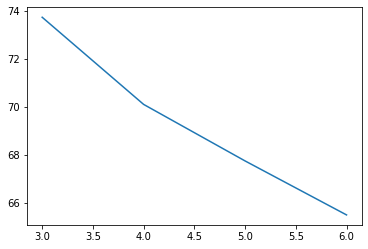

In [115]:
plt.plot(np.arange(3, 7),min_degs)

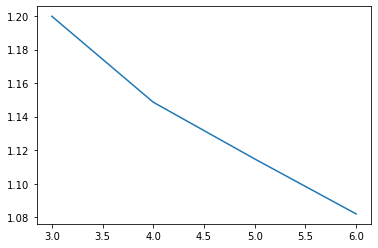

In [117]:
plt.plot(np.arange(3, 7),min_dists)

In [173]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.05,decay_steps=13, decay_rate=0.96, staircase=True)

In [171]:
lr_schedule(N*13)

<tf.Tensor: shape=(), dtype=float32, numpy=0.00084351405>

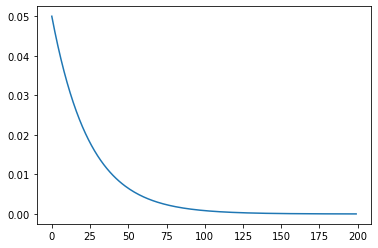

In [174]:
N=200
plt.plot(np.arange(N), lr_schedule(13 *np.arange(N)))

In [148]:
siamese_model.siamese_network.layers[1].summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
for i in tf.range(tf_labels.shape):
    print(i)

In [194]:
tf_labels[i]

<tf.Tensor: shape=(), dtype=string, numpy=b'4048'>

VAL - fraction of True accepts of all image pairs with same labels.

FAR - fraction of False accepts of all image pairs with different labels.


d is small:

images that are close but not within d are not considered same, so accepts will be low, VAL and FAR will be small.


d is large,

any pair of images are considered the same, VAL and FAR will be 1




In [51]:
embeddings = np.random.normal(size=(128, 256))
embeddings =  embeddings/np.linalg.norm(embeddings, axis=1, keepdims=1)

In [52]:
X_norm_sq = np.sum(embeddings**2, axis=1)
kernel = X_norm_sq[:, np.newaxis] + X_norm_sq[np.newaxis, :] - 2*np.dot(embeddings, embeddings.T)
kernel2=np.sqrt(np.abs(kernel))

In [53]:
np.max(kernel), np.min(kernel)

(2.4907560713005803, -1.3322676295501878e-15)

In [54]:
np.max(kernel2), np.min(kernel2)

(1.578212935981891, 0.0)